# Quantam Data Part (Orginal Paper)

# Ignore Warning

In [206]:
import warnings
warnings.filterwarnings('ignore')

# Save Figure

In [207]:
# Save figure function
import os
from pathlib import Path
from matplotlib import pyplot as plt
IMAGES_PATH = Path() / "IMAGES" 
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [208]:
'''


Electronic structure problem with classical shadows, as presented in https://arxiv.org/abs/2103.07510
This code uses Qiskit as platform. 
'''

import time
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, execute
from qiskit_aer import QasmSimulator

from qiskit.quantum_info import SparsePauliOp

from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.algorithms import GroundStateEigensolver
from qiskit_nature.second_q.mappers import BravyiKitaevMapper, JordanWignerMapper, ParityMapper

from qiskit.circuit.library import TwoLocal

from qiskit.algorithms.minimum_eigensolvers import VQE
from qiskit.algorithms.optimizers import SLSQP, COBYLA, SPSA

# Estimator primitive is based on the Statevector construct = algebraic simulation
from qiskit.primitives import Estimator 

from modified_derandomization import modified_derandomized_classical_shadow
from data_acquisition_shadow import derandomized_classical_shadow
from prediction_shadow import estimate_exp

import qiskit_nature
qiskit_nature.settings.use_pauli_sum_op = False
import h5py
H5PY_DEFAULT_READONLY=1





driver = PySCFDriver(
    atom="H 0 0 0; H 0 0 0.735",
    basis="6-31g",
    charge=0,
    spin=0,
    unit=DistanceUnit.ANGSTROM,
)

problem = driver.run()

hamiltonian = problem.hamiltonian
second_q_op = hamiltonian.second_q_op()

mapper = JordanWignerMapper()
bkencoded_hamiltonian = mapper.map(second_q_op)

#print(bkencoded_hamiltonian)

In [209]:
def process_hamiltonian(hamiltonian, derandomize = False):

    hamiltonian_observables = []
    hamiltonian_coefficients = []

    for observable in hamiltonian.paulis:
        op_list = []
        for op_index, pauli_op in enumerate(observable):
            pauli_op = str(pauli_op)
            if pauli_op == 'I' or pauli_op == 'X' or pauli_op == 'Y' or pauli_op == 'Z':
                op_list.append((pauli_op, op_index))
        hamiltonian_observables.append(op_list)
    
    hamiltonian_coefficients = hamiltonian.coeffs.real
    
    system_size = len(hamiltonian_observables[0])

    # removing all occurrences of Pauli-I, for all-Pauli-I there is an empty list left
    # these observables are needed for estimate_exp()
    observables_xyze = []

    for observable in hamiltonian_observables:
        XYZE = []
        for pauli in observable:
            if pauli[0] != 'I':
                XYZE.append(pauli)
        observables_xyze.append(XYZE)   
    
    # derandomisation procedure requires that coefficients are non-negative
    if derandomize == True:
        absolute_coefficients = [abs(coeffcient) for coeffcient in hamiltonian_coefficients]

        # removing the empty list as well
        # these observables are needed for derandomisation procedure
        observables_xyz = []
        for idx, observable in enumerate(observables_xyze):
            if observable:
                observables_xyz.append(observable)
            else:
                absolute_coefficients.pop(idx)
        
        return system_size, observables_xyze, observables_xyz, hamiltonian_coefficients, absolute_coefficients
    
    return system_size, observables_xyze, hamiltonian_coefficients



# process the Hamiltonian to obtain properly formatted data
hamiltonian_data = process_hamiltonian(bkencoded_hamiltonian, derandomize = True)
system_size, observables_xyze, observables_xyz, hamiltonian_coefficients, absolute_coefficients = hamiltonian_data

#print('HAMILTONIAN\n', observables_xyze)

In [210]:
'''
VARIATIONAL ANSATZ
Note that for molecules other than H_2 you may need to specify a different number of reps.
'''

reps = 5
ansatz = TwoLocal(num_qubits=system_size, reps=reps, rotation_blocks=['ry', 'rz'],
                entanglement_blocks='cz', skip_final_rotation_layer=False)
ansatz.decompose().draw('mpl')






def basis_change_circuit(pauli_op):

    #   Generating circuit with just the basis change operators
    #
    #       pauli_op: n-qubit Pauli operator

    basis_change = QuantumCircuit(ansatz.num_qubits, ansatz.num_qubits)

    for idx, op in enumerate(pauli_op):
        
        if op == 'X':
            basis_change.h(idx)
        if op == 'Y':
            basis_change.h(idx)
            basis_change.p(-np.pi/2, idx)
            
    return basis_change

    
    


def ground_state_energy_from_shadow(operators, params):
    
    backend = QasmSimulator(method='statevector', shots=1)
    
    pauli_op_dict = Counter(tuple(x) for x in operators)    
    
    
    shadow = []
    for pauli_op in pauli_op_dict:
        
        qc = ansatz.bind_parameters(params)
        qc = qc.compose(basis_change_circuit(pauli_op))                                   # changed
        qc.measure(reversed(range(system_size)), range(system_size))                      # changed
        
        result = execute(qc, backend, shots=pauli_op_dict[pauli_op]).result()
        counts = result.get_counts()    # given in order q0 q1 ... qn-1 after reversal in qc.measure
        
        for count in counts:
            for _ in range(counts[count]): # number of repeated measurement values

                output_str = list(count)   
                output = [int(i) for i in output_str]
                eigenvals = [x+1 if x == 0 else x-2 for x in output]
                snapshot = [(op, eigenval) for op, eigenval in zip(pauli_op, eigenvals)]
                
                shadow.append(snapshot)
    
    
    expectation_value = 0.0
    for term, weight in zip(observables_xyze, hamiltonian_coefficients):
        
        sum_product, match_count = estimate_exp(shadow, term)
        
        if match_count != 0:
            expectation_value += (weight * sum_product / match_count)

    return expectation_value
      

In [211]:
'''
Running VQE on the Hamiltonian obtained from PySCFDriver using Statevector simulator (Estimator primitive)
'''

estimator = Estimator()
# If shots = None, it calculates the exact expectation values. Otherwise, it samples from normal distributions 
# with standard errors as standard deviations using normal distribution approximation.
estimator.set_options(shots = None)
vqe_solver = VQE(estimator, ansatz, SLSQP(maxiter=3000))

calc = GroundStateEigensolver(mapper, vqe_solver)
result = calc.solve(problem)
print(result.raw_result)

{   'aux_operators_evaluated': {   'AngularMomentum': (0.00874634276483971, {}),
                                   'Magnetization': (0.0039435085639482614, {}),
                                   'ParticleNumber': (2.0016262878404953, {}),
                                   'XDipole': (0.0, {}),
                                   'YDipole': (0.0, {}),
                                   'ZDipole': (1.3897118912815998, {})},
    'cost_function_evals': 12518,
    'eigenvalue': -1.857548078388484,
    'optimal_circuit': <qiskit.circuit.library.n_local.two_local.TwoLocal object at 0x7fdc5a31bf10>,
    'optimal_parameters': {   ParameterVectorElement(θ[8]): 3.920409075477748,
                              ParameterVectorElement(θ[7]): 2.6082654758571953,
                              ParameterVectorElement(θ[9]): 4.918574226504571,
                              ParameterVectorElement(θ[10]): 0.019904820381063434,
                              ParameterVectorElement(θ[11]): 3.757236881718382

NUMBER OF OPERATORS | DERANDOMISED OPERATORS | AVERAGE RMSE ERROR

EXPERIMENT 0: GROUND STATE ENERGY FOUND = 1.5157362057978865
EXPERIMENT 1: GROUND STATE ENERGY FOUND = 1.5282369354901175
EXPERIMENT 2: GROUND STATE ENERGY FOUND = 1.5126672602714994
EXPERIMENT 3: GROUND STATE ENERGY FOUND = 1.536892429157921
EXPERIMENT 4: GROUND STATE ENERGY FOUND = 1.5368977314062997
EXPERIMENT 5: GROUND STATE ENERGY FOUND = 1.529594201103436
EXPERIMENT 6: GROUND STATE ENERGY FOUND = 1.5414816621071659
EXPERIMENT 7: GROUND STATE ENERGY FOUND = 1.5280945878255883
EXPERIMENT 8: GROUND STATE ENERGY FOUND = 1.539609523662848
EXPERIMENT 9: GROUND STATE ENERGY FOUND = 1.5084293346352222
50 | Counter({('X', 'X', 'X', 'X', 'X', 'X', 'X', 'X'): 50}) | 3.3853304586957775
EXPERIMENT 0: GROUND STATE ENERGY FOUND = -0.3740371169524884
EXPERIMENT 1: GROUND STATE ENERGY FOUND = -0.37031904297295415
EXPERIMENT 2: GROUND STATE ENERGY FOUND = -0.37328006362001737
EXPERIMENT 3: GROUND STATE ENERGY FOUND = -0.37189249067

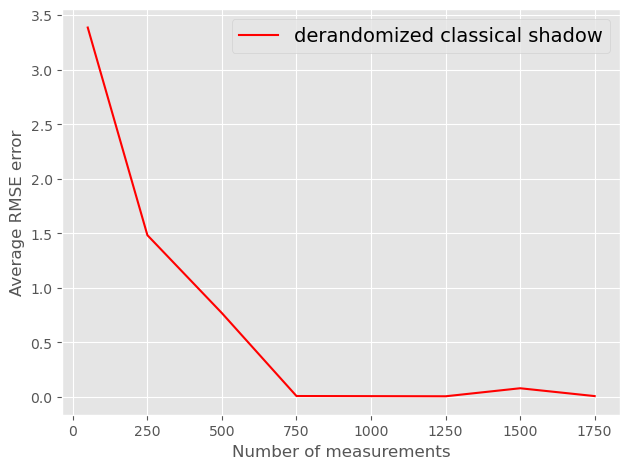

In [212]:
'''
EXPERIMENTS
'''

start_time = time.time()
rmse_errors = []




print('NUMBER OF OPERATORS | DERANDOMISED OPERATORS | AVERAGE RMSE ERROR\n')
measurement_range = [50, 250, 500, 750, 1000, 1250, 1500, 1750]

for num_operators in measurement_range:   
    
    derandomized_hamiltonian = modified_derandomized_classical_shadow(observables_xyz, num_operators, 
                                                                      system_size, weight=absolute_coefficients)

    tuples = (tuple(pauli) for pauli in derandomized_hamiltonian)
    counts = Counter(tuples)
    
    expectation_values = []
    test = []
    
    num_experiments = 10


    for iteration in range(num_experiments):
        
        expectation_value = ground_state_energy_from_shadow(derandomized_hamiltonian, result.raw_result.optimal_point)
        expectation_values.append(expectation_value)
        
        test.append (expectation_value)
                
        print("EXPERIMENT {}: GROUND STATE ENERGY FOUND = {}".format(iteration, expectation_value))


    rmse_derandomised_cs = np.sqrt(np.sum([(expectation_values[i] - result.raw_result.optimal_value)**2 
                                           for i in range(num_experiments)])/num_experiments)

    rmse_errors.append(rmse_derandomised_cs)
    
    print('{} | {} | {}'.format(num_operators, counts, rmse_derandomised_cs))


elapsed_time = time.time() - start_time
print("Execution time = ", time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

          
points = measurement_range
num_points = len(measurement_range)

plt.plot([i for i in points], [rmse_errors[i] for i in range(num_points)], 'r', label='derandomized classical shadow')
plt.xlabel('Number of measurements')
plt.ylabel('Average RMSE error')
plt.legend(loc=1)

save_fig("Derandomize classical shadow graph")


In [213]:
'''
ESTIMATE THE HAMILTONIAN ON OPTIMAL PARAMETERS
'''

qc = ansatz.bind_parameters(result.raw_result.optimal_point)
job_ham = estimator.run(qc, bkencoded_hamiltonian)
result_h = job_ham.result()
print(f">>> Expectation value of the Hamiltonian: {result_h.values[0]}")

store_term = []
store_coff = []


expectation_values = []
for index, term in enumerate(bkencoded_hamiltonian.paulis):
    job = estimator.run(qc, term) 
    #print(f">>> Job ID: {job.job_id()}")
    #print(f">>> Job Status: {job.status()}")
    result2 = job.result()
    #print(f">>> {result2}")
    expval = result2.values[0]
    expectation_values.append(expval)
    print("  > Expectation value of {} with coeff {}: {}".format(term, bkencoded_hamiltonian.coeffs.real[index], expval))
    store_term.append(term)
    
    store_coff.append(bkencoded_hamiltonian.coeffs.real[index])
    
    
    
total_expval = 0.0
for index, expval in enumerate(expectation_values):
    total_expval += expval * bkencoded_hamiltonian.coeffs.real[index]

print('>>> Total expectation value from summing up expectation values of all terms', total_expval)

>>> Expectation value of the Hamiltonian: -1.857548078388484
  > Expectation value of IIIIIIII with coeff 1.5280210592332588: 1.0
  > Expectation value of IIIIIIIZ with coeff -0.27221525735100477: -0.9911027170801109
  > Expectation value of IIIIIYZY with coeff 0.08812294324841621: 0.007726127716796236
  > Expectation value of IIIIIXZX with coeff 0.08812294324841621: 0.007692332520955858
  > Expectation value of IIIIIIZI with coeff -0.4051688984463241: 0.986823200193265
  > Expectation value of IIIIYZYI with coeff 0.05206368066441207: 0.008483892708948303
  > Expectation value of IIIIXZXI with coeff 0.05206368066441207: 0.007978258387390018
  > Expectation value of IIIIIZII with coeff -0.6893596033215874: 0.9999650487170514
  > Expectation value of IIIIZIII with coeff -1.042222589081817: 0.9948011632014016
  > Expectation value of IIIZIIII with coeff -0.27221525735100477: -0.9817031363084259
  > Expectation value of IYZYIIII with coeff 0.08812294324841621: 3.554919583968468e-08
  > Exp

# Classical ML (Extension of paper)

# Dataset Creation

In [214]:
import pandas as pd
import numpy as np

In [215]:
store_term

[Pauli('IIIIIIII'),
 Pauli('IIIIIIIZ'),
 Pauli('IIIIIYZY'),
 Pauli('IIIIIXZX'),
 Pauli('IIIIIIZI'),
 Pauli('IIIIYZYI'),
 Pauli('IIIIXZXI'),
 Pauli('IIIIIZII'),
 Pauli('IIIIZIII'),
 Pauli('IIIZIIII'),
 Pauli('IYZYIIII'),
 Pauli('IXZXIIII'),
 Pauli('IIZIIIII'),
 Pauli('YZYIIIII'),
 Pauli('XZXIIIII'),
 Pauli('IZIIIIII'),
 Pauli('ZIIIIIII'),
 Pauli('IIIIIIZZ'),
 Pauli('IIIIYZYZ'),
 Pauli('IIIIXZXZ'),
 Pauli('IIIIIYIY'),
 Pauli('IIIIIXIX'),
 Pauli('IIIIYXXY'),
 Pauli('IIIIYYYY'),
 Pauli('IIIIXXYY'),
 Pauli('IIIIYYXX'),
 Pauli('IIIIXXXX'),
 Pauli('IIIIXYYX'),
 Pauli('IIIIIZIZ'),
 Pauli('IIIIZIIZ'),
 Pauli('IIIIZYZY'),
 Pauli('IIIIZXZX'),
 Pauli('IIIZIIIZ'),
 Pauli('IIIZIYZY'),
 Pauli('IIIZIXZX'),
 Pauli('IIYYIIYY'),
 Pauli('IIXXIIYY'),
 Pauli('IIYYIIXX'),
 Pauli('IIXXIIXX'),
 Pauli('IIYYYZZY'),
 Pauli('IIXXYZZY'),
 Pauli('IIYYXZZX'),
 Pauli('IIXXXZZX'),
 Pauli('IYZYIIIZ'),
 Pauli('IXZXIIIZ'),
 Pauli('IYZYIYZY'),
 Pauli('IXZXIYZY'),
 Pauli('IYZYIXZX'),
 Pauli('IXZXIXZX'),
 Pauli('YZZYIIYY'),


In [216]:
store_coff

[1.5280210592332588,
 -0.27221525735100477,
 0.08812294324841621,
 0.08812294324841621,
 -0.4051688984463241,
 0.05206368066441207,
 0.05206368066441207,
 -0.6893596033215874,
 -1.042222589081817,
 -0.27221525735100477,
 0.08812294324841621,
 0.08812294324841621,
 -0.40516889844632403,
 0.05206368066441207,
 0.05206368066441207,
 -0.6893596033215872,
 -1.042222589081817,
 0.08852206158533461,
 -0.01603330558019096,
 -0.01603330558019096,
 -0.017356000955093254,
 -0.017356000955093254,
 0.012970529275601975,
 0.015318666338180914,
 0.002348137062578927,
 0.002348137062578927,
 0.015318666338180914,
 0.012970529275601975,
 0.10571999330831898,
 0.13179934521156542,
 -0.019831904813811713,
 -0.019831904813811713,
 0.16302461641468569,
 -0.04197705526657953,
 -0.04197705526657953,
 0.01986207955163346,
 0.01986207955163346,
 0.01986207955163346,
 0.01986207955163346,
 0.019808855464805146,
 0.019808855464805146,
 0.019808855464805146,
 0.019808855464805146,
 -0.041977055266579535,
 -0.0419

In [217]:
expectation_values

[1.0,
 -0.9911027170801109,
 0.007726127716796236,
 0.007692332520955858,
 0.986823200193265,
 0.008483892708948303,
 0.007978258387390018,
 0.9999650487170514,
 0.9948011632014016,
 -0.9817031363084259,
 3.554919583968468e-08,
 1.3415476265857906e-07,
 0.9913076037892058,
 0.0005901999427330195,
 0.006469985554642158,
 0.9999995617485469,
 0.9966567000580735,
 -0.990659699690109,
 -0.0005089862526784058,
 -4.114578935958916e-06,
 0.0077854409633801944,
 0.007872089336164198,
 2.3023164816231663e-05,
 2.072379391876328e-05,
 2.2524222020346355e-05,
 -2.8421655711963555e-05,
 0.0001332403728134534,
 -1.7101406608661936e-05,
 -0.9911333599688407,
 -0.9909078837882497,
 0.007702569653191915,
 0.007617362313344764,
 0.9905335281149785,
 -0.0077616578921726265,
 -0.007793869808389868,
 -0.10047394263249267,
 -0.10048216013846593,
 -0.10048181633476673,
 -0.10045894639040424,
 -0.06295864358833805,
 -0.06294812884555777,
 -0.06298686655244702,
 -0.06296773807737759,
 -6.728868911770411e-07,


In [218]:
array2 = np.array (store_coff)
array3 = np.array (expectation_values)

In [219]:
# read text file into pandas DataFrame
array1 = pd.read_csv("pauli.txt", sep="\t")

# display DataFrame
print(array1)
# array1.to_csv('file2.csv')

     [IIIIIIII,
0     IIIIIIIZ,
1     IIIIIYZY,
2     IIIIIXZX,
3     IIIIIIZI,
4     IIIIYZYI,
..          ...
179   IZZIIIII,
180   YIYIIIII,
181   XIXIIIII,
182   ZIZIIIII,
183   ZZIIIIII]

[184 rows x 1 columns]


In [220]:
df = pd.read_csv('file2.csv')
array1 = df.to_numpy()

In [221]:
print(array1)

[[' IIIIIIIZ,']
 [' IIIIIYZY,']
 [' IIIIIXZX,']
 [' IIIIIIZI,']
 [' IIIIYZYI,']
 [' IIIIXZXI,']
 [' IIIIIZII,']
 [' IIIIZIII,']
 [' IIIZIIII,']
 [' IYZYIIII,']
 [' IXZXIIII,']
 [' IIZIIIII,']
 [' YZYIIIII,']
 [' XZXIIIII,']
 [' IZIIIIII,']
 [' ZIIIIIII,']
 [' IIIIIIZZ,']
 [' IIIIYZYZ,']
 [' IIIIXZXZ,']
 [' IIIIIYIY,']
 [' IIIIIXIX,']
 [' IIIIYXXY,']
 [' IIIIYYYY,']
 [' IIIIXXYY,']
 [' IIIIYYXX,']
 [' IIIIXXXX,']
 [' IIIIXYYX,']
 [' IIIIIZIZ,']
 [' IIIIZIIZ,']
 [' IIIIZYZY,']
 [' IIIIZXZX,']
 [' IIIZIIIZ,']
 [' IIIZIYZY,']
 [' IIIZIXZX,']
 [' IIYYIIYY,']
 [' IIXXIIYY,']
 [' IIYYIIXX,']
 [' IIXXIIXX,']
 [' IIYYYZZY,']
 [' IIXXYZZY,']
 [' IIYYXZZX,']
 [' IIXXXZZX,']
 [' IYZYIIIZ,']
 [' IXZXIIIZ,']
 [' IYZYIYZY,']
 [' IXZXIYZY,']
 [' IYZYIXZX,']
 [' IXZXIXZX,']
 [' YZZYIIYY,']
 [' XZZXIIYY,']
 [' YZZYIIXX,']
 [' XZZXIIXX,']
 [' YZZYYZZY,']
 [' XZZXYZZY,']
 [' YZZYXZZX,']
 [' XZZXXZZX,']
 [' IIZIIIIZ,']
 [' IIZIIYZY,']
 [' IIZIIXZX,']
 [' IYYIIIYY,']
 [' IXXIIIYY,']
 [' IYYIIIXX,']
 [' IXXI

In [222]:
import pandas as pd

df = pd.DataFrame({'Coefficient': array2,
                   'Expectation Values': array3,
                   })

# df['Paulies'] = df.apply(lambda s: s.to_numpy(), axis=1)

print(df)

     Coefficient  Expectation Values
0       1.528021            1.000000
1      -0.272215           -0.991103
2       0.088123            0.007726
3       0.088123            0.007692
4      -0.405169            0.986823
..           ...                 ...
180     0.086215            0.991308
181    -0.023950            0.000590
182    -0.023950            0.006470
183     0.093777            0.991137
184     0.106564            0.996656

[185 rows x 2 columns]


In [223]:
df.to_csv('file1.csv')

# Figure save function

In [224]:
# Save figure function
import os
from pathlib import Path
from matplotlib import pyplot as plt
IMAGES_PATH = Path() / "IMAGES" 
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Import Libraries

In [225]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [226]:
df = pd.read_csv('Classical_data_H2.csv')
df.head(100)

Pauli Operators  Coefficient  Expectation Values
0         IIIIIIII     1.528021            1.000000
1         IIIIIIIZ    -0.272215           -0.981762
2         IIIIIYZY     0.088123            0.004820
3         IIIIIXZX     0.088123            0.004774
4         IIIIIIZI    -0.405169            0.985584
..             ...          ...                 ...
95        IIYYIYYI    -0.004951           -0.000030
96        IIXXIYYI    -0.004951           -0.000030
97        IIYYIXXI    -0.004951           -0.000654
98        IIXXIXXI    -0.004951           -0.000655
99        IYZYIIZI    -0.012405            0.000753

[100 rows x 3 columns]

# Generate informaion about dataset

In [227]:
from ydata_profiling import ProfileReport
from ydata_profiling.utils.cache import cache_file
report=ProfileReport(
    df,title="Quality_Test", explorative=True)
report.to_file("dataset_information.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

# Discover and Visualize the Data to Gain Insights

In [228]:
df['Pauli Operators'].value_counts()

Pauli Operators
IIIIIIII     1
 YYIIIXXI    1
 YZYIYZYI    1
 XZXIYZYI    1
 YZYIXZXI    1
            ..
 IYYIYZZY    1
 IXXIYZZY    1
 IYYIXZZX    1
 IXXIXZZX    1
 ZZIIIIII    1
Name: count, Length: 185, dtype: int64

In [229]:
df['Coefficient'].value_counts()

Coefficient
-0.005281    8
 0.030721    8
-0.000517    8
-0.004951    8
-0.018251    8
-0.020600    8
-0.019809    8
 0.034558    4
 0.035842    4
-0.029954    4
 0.023950    4
-0.050553    4
 0.031606    4
 0.013600    4
 0.009022    4
 0.016784    4
 0.024467    4
 0.041922    4
 0.027407    4
-0.012405    4
 0.019862    4
-0.002348    4
 0.088123    4
-0.052064    4
 0.016033    4
-0.017356    4
-0.041977    4
-0.015319    4
-0.012971    4
-0.019832    4
 0.105720    2
 0.133127    2
 0.108384    2
 0.110560    2
-0.405169    2
 0.095237    2
-0.689360    2
-1.042223    2
 0.088522    2
 0.138170    2
 0.093777    2
-0.272215    2
 0.086215    2
 0.166357    2
 0.131799    2
 0.106564    2
 0.115864    1
 1.528021    1
 0.096381    1
 0.163025    1
 0.185777    1
Name: count, dtype: int64

In [230]:
df['Expectation Values'].value_counts()

Expectation Values
 1.000000e+00    1
 2.260000e-06    1
 1.241479e-02    1
 9.300000e-05    1
 9.280000e-05    1
                ..
-4.610000e-07    1
-1.250000e-06    1
 1.790000e-06    1
-3.530000e-07    1
 9.918790e-01    1
Name: count, Length: 185, dtype: int64

# Visualize the Data

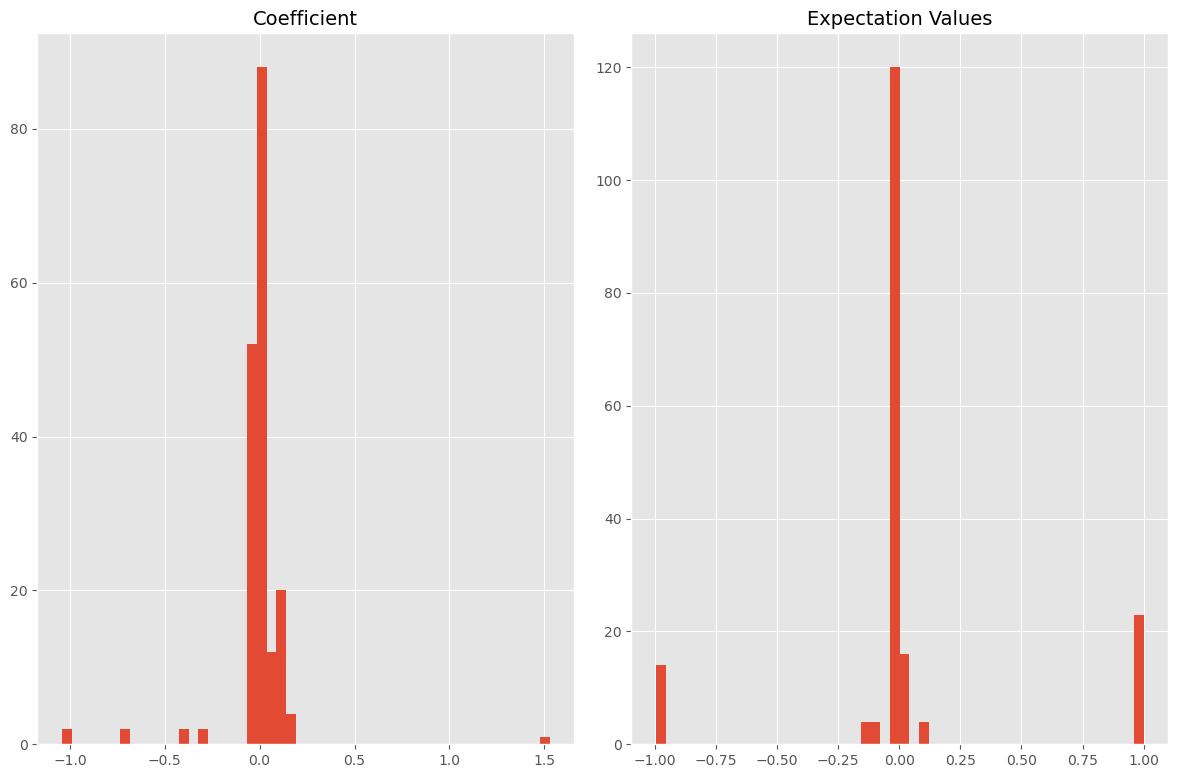

In [231]:
# extra code – the next 5 lines define the default font sizes
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
df.hist(bins=50, figsize=(12, 8))
save_fig("attribute_histogram_plots")  # extra code
plt.show()

In [232]:
coefficients = df['Coefficient']
expectation_value = df['Expectation Values']

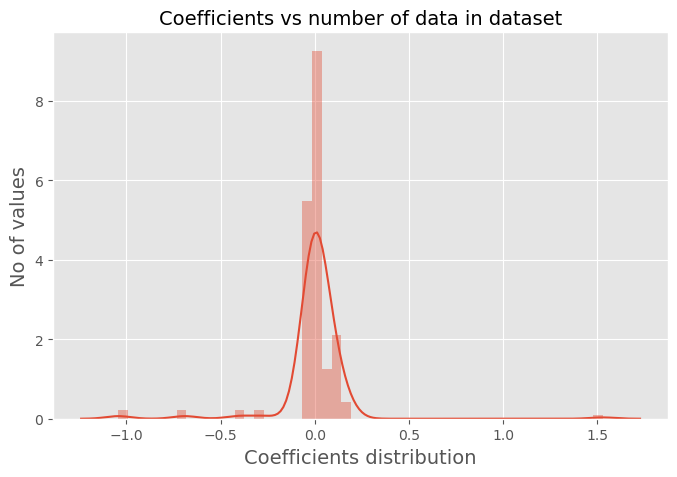

In [233]:
# setting the dimensions of the plot
fig, ax = plt.subplots(figsize=(7, 5))
sns.distplot(coefficients).set_title("Coefficients vs number of data in dataset")
plt.xlabel("Coefficients distribution")
plt.ylabel("No of values")
save_fig("Displot of coefficient values")

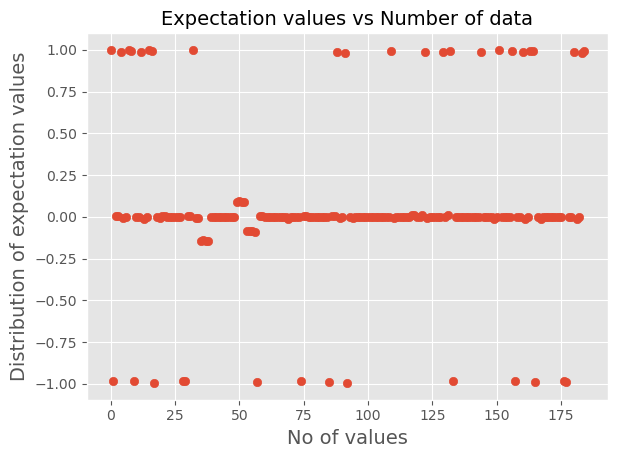

In [234]:
import matplotlib.pyplot as plt
plt.title("Expectation values vs Number of data")
plt.xlabel("No of values")
plt.ylabel("Distribution of expectation values")
plt.scatter(df.index,expectation_value)
save_fig("Plotting of expectation values vs Number of data in dataset using scatterplot")
plt.show()

# Information about data types

In [235]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185 entries, 0 to 184
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Pauli Operators     185 non-null    object 
 1   Coefficient         185 non-null    float64
 2   Expectation Values  185 non-null    float64
dtypes: float64(2), object(1)
memory usage: 4.5+ KB


### Check data types of dataframe

In [236]:
df.dtypes

Pauli Operators        object
Coefficient           float64
Expectation Values    float64
dtype: object

In [237]:
df.describe()

Coefficient  Expectation Values
count   185.000000          185.000000
mean      0.001103            0.045530
std       0.187362            0.442551
min      -1.042223           -0.996111
25%      -0.018251           -0.000406
50%      -0.000517            0.000001
75%       0.031606            0.000765
max       1.528021            1.000000

In [238]:
df.shape

(185, 3)

In [239]:
# Unique Values 
df.nunique()

Pauli Operators       185
Coefficient            51
Expectation Values    185
dtype: int64

In [240]:
df.columns

Index(['Pauli Operators', 'Coefficient', 'Expectation Values'], dtype='object')

In [241]:
df.head(100)

Pauli Operators  Coefficient  Expectation Values
0         IIIIIIII     1.528021            1.000000
1         IIIIIIIZ    -0.272215           -0.981762
2         IIIIIYZY     0.088123            0.004820
3         IIIIIXZX     0.088123            0.004774
4         IIIIIIZI    -0.405169            0.985584
..             ...          ...                 ...
95        IIYYIYYI    -0.004951           -0.000030
96        IIXXIYYI    -0.004951           -0.000030
97        IIYYIXXI    -0.004951           -0.000654
98        IIXXIXXI    -0.004951           -0.000655
99        IYZYIIZI    -0.012405            0.000753

[100 rows x 3 columns]

# Feature Scaling

In [242]:
from sklearn.preprocessing import MinMaxScaler
scale_vars = ['Coefficient', 'Expectation Values']
scaler = MinMaxScaler()
df[scale_vars] = scaler.fit_transform(df[scale_vars])

In [243]:
df.head(100)

Pauli Operators  Coefficient  Expectation Values
0         IIIIIIII     1.000000            1.000000
1         IIIIIIIZ     0.299585            0.007188
2         IIIIIYZY     0.439781            0.501440
3         IIIIIXZX     0.439781            0.501418
4         IIIIIIZI     0.247857            0.992778
..             ...          ...                 ...
95        IIYYIYYI     0.403570            0.499011
96        IIXXIYYI     0.403570            0.499011
97        IIYYIXXI     0.403570            0.498698
98        IIXXIXXI     0.403570            0.498698
99        IYZYIIZI     0.400669            0.499403

[100 rows x 3 columns]

In [244]:
df['Expectation Values']

0      1.000000
1      0.007188
2      0.501440
3      0.501418
4      0.992778
         ...   
180    0.994888
181    0.492884
182    0.498598
183    0.990870
184    0.995932
Name: Expectation Values, Length: 185, dtype: float64

# Defining Features and Label

In [245]:
X = df.drop(columns = 'Expectation Values') 	
y = df['Expectation Values']

In [246]:
print(X)

    Pauli Operators  Coefficient
0          IIIIIIII     1.000000
1          IIIIIIIZ     0.299585
2          IIIIIYZY     0.439781
3          IIIIIXZX     0.439781
4          IIIIIIZI     0.247857
..              ...          ...
180        IZZIIIII     0.439039
181        YIYIIIII     0.414814
182        XIXIIIII     0.414814
183        ZIZIIIII     0.441981
184        ZZIIIIII     0.446956

[185 rows x 2 columns]


In [247]:
y

0      1.000000
1      0.007188
2      0.501440
3      0.501418
4      0.992778
         ...   
180    0.994888
181    0.492884
182    0.498598
183    0.990870
184    0.995932
Name: Expectation Values, Length: 185, dtype: float64

# Convertion of catagorical to numerical data

## Bag Of Words (BOW)

In [248]:
# from sklearn.preprocessing import OneHotEncoder
# from sklearn.compose import ColumnTransformer
# import pandas as pd
# from sklearn.feature_extraction.text import CountVectorizer

# catagorical_features = df['Pauli Operators']

# data = pd.DataFrame({'Text': catagorical_features})

# # Initialize the CountVectorizer
# vectorizer = CountVectorizer()


# # Fit and transform the text data
# bow_vectors = vectorizer.fit_transform(data['Text'])

# # Convert the BOW vectors to a DataFrame
# bow_df = pd.DataFrame(bow_vectors.toarray(), columns=vectorizer.get_feature_names_out())


# # Print the BOW DataFrame
# bow_df.head()

# # Cofficients
# df2 = X['Coefficient']

# # Combine dataframe
# transformed_X = pd.concat([bow_df, df2], axis=1, join='inner')

In [249]:
# bow_df.head()

## TF-IDF Vectorizer

In [250]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer


catagorical_features = df['Pauli Operators']

data = pd.DataFrame({'Text': catagorical_features})

# Initialize the TF-IDF Vectorizer
vectorizer = TfidfVectorizer()

# Fit and transform the text data
tfidf_vectors = vectorizer.fit_transform(data['Text'])

# Convert the TF-IDF vectors to a DataFrame
tfidf_df = pd.DataFrame(tfidf_vectors.toarray(), columns=vectorizer.get_feature_names_out())

# Print the TF-IDF DataFrame
tfidf_df.head()


# Cofficients
df2 = X['Coefficient']

# Combine dataframe
transformed_X = pd.concat([tfidf_df, df2], axis=1, join='inner')

In [251]:
tfidf_df.head()

iiiiiiii  iiiiiiiz  iiiiiizi  iiiiiizz  iiiiixix  iiiiixzx  iiiiiyiy  \
0       1.0       0.0       0.0       0.0       0.0       0.0       0.0   
1       0.0       1.0       0.0       0.0       0.0       0.0       0.0   
2       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
3       0.0       0.0       0.0       0.0       0.0       1.0       0.0   
4       0.0       0.0       1.0       0.0       0.0       0.0       0.0   

   iiiiiyzy  iiiiizii  iiiiiziz  ...  ziiiiyzy  ziiiizii  ziiixzxi  ziiiyzyi  \
0       0.0       0.0       0.0  ...       0.0       0.0       0.0       0.0   
1       0.0       0.0       0.0  ...       0.0       0.0       0.0       0.0   
2       1.0       0.0       0.0  ...       0.0       0.0       0.0       0.0   
3       0.0       0.0       0.0  ...       0.0       0.0       0.0       0.0   
4       0.0       0.0       0.0  ...       0.0       0.0       0.0       0.0   

   ziiiziii  ziiziiii  ziziiiii  zxzxiiii  zyzyiiii  zziiiiii  
0       0.0       0.0       0.0       0.0       0.0       0.0  
1       0.0       0.0       0.0       0.0       0.0       0.0  
2       0.0       0.0       0.0       0.0       0.0       0.0  
3       0.0       0.0       0.0       0.0       0.0       0.0  
4       0.0       0.0       0.0       0.0       0.0       0.0  

[5 rows x 185 columns]

## Dataframe after converting categorical to numarical value

In [252]:
print (transformed_X)

     iiiiiiii  iiiiiiiz  iiiiiizi  iiiiiizz  iiiiixix  iiiiixzx  iiiiiyiy  \
0         1.0       0.0       0.0       0.0       0.0       0.0       0.0   
1         0.0       1.0       0.0       0.0       0.0       0.0       0.0   
2         0.0       0.0       0.0       0.0       0.0       0.0       0.0   
3         0.0       0.0       0.0       0.0       0.0       1.0       0.0   
4         0.0       0.0       1.0       0.0       0.0       0.0       0.0   
..        ...       ...       ...       ...       ...       ...       ...   
180       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
181       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
182       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
183       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
184       0.0       0.0       0.0       0.0       0.0       0.0       0.0   

     iiiiiyzy  iiiiizii  iiiiiziz  ...  ziiiizii  ziiixzxi  ziiiyzyi  \
0  

# Split the dataset between train  and test set

In [253]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(transformed_X, y, test_size=0.20, random_state= 46)

In [254]:
print(X_train)

     iiiiiiii  iiiiiiiz  iiiiiizi  iiiiiizz  iiiiixix  iiiiixzx  iiiiiyiy  \
162       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
70        0.0       0.0       0.0       0.0       0.0       0.0       0.0   
83        0.0       0.0       0.0       0.0       0.0       0.0       0.0   
138       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
106       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
..        ...       ...       ...       ...       ...       ...       ...   
146       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
147       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
116       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
40        0.0       0.0       0.0       0.0       0.0       0.0       0.0   
69        0.0       0.0       0.0       0.0       0.0       0.0       0.0   

     iiiiiyzy  iiiiizii  iiiiiziz  ...  ziiiizii  ziiixzxi  ziiiyzyi  \
162

In [255]:
exp_X_train = X_train
exp_X_test = X_test
exp_y_train = y_train
exp_y_test = y_test

# Predictions and model building

# Machine Learning techniques

### Import Libraries

In [256]:
import scikitplot as skplt
import pickle
from sklearn.model_selection import cross_val_score
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import mean_squared_error

from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.linear_model import ElasticNet
import catboost as cb
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

### Model Evaluation

In [257]:





def Results(clf):
    print ("Algorithm: ", clf)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    print ('Mean square error: ', "{:.3f}".format(mean_squared_error(y_test,y_pred)))
    print ('Root mean square error: ', "{:.3f}".format(root_mean_squared_error(y_test,y_pred)))
    print("\n")

In [258]:


lr = linear_model.LinearRegression()

rf = RandomForestRegressor(n_estimators= 200, max_depth=500, random_state=0)

params = {
    "n_estimators": 500,
    "max_depth": 4,
    "min_samples_split": 5,
    "learning_rate": 0.01,
    "loss": "squared_error",
}
reg = GradientBoostingRegressor(**params)


eln = ElasticNet(random_state=0)

cat = cb.CatBoostRegressor(loss_function='RMSE')

rfr = RandomForestRegressor(n_estimators=1000)




regressors = [lr,rf,reg,eln,cat,rfr]

for clf in regressors:
    Results(clf)


Algorithm:  LinearRegression()
Mean square error:  0.081
Root mean square error:  0.285


Algorithm:  RandomForestRegressor(max_depth=500, n_estimators=200, random_state=0)
Mean square error:  0.063
Root mean square error:  0.251


Algorithm:  GradientBoostingRegressor(learning_rate=0.01, max_depth=4, min_samples_split=5,
                          n_estimators=500)
Mean square error:  0.066
Root mean square error:  0.256


Algorithm:  ElasticNet(random_state=0)
Mean square error:  0.059
Root mean square error:  0.243


Algorithm:  <catboost.core.CatBoostRegressor object at 0x7fdc62918790>
Learning rate set to 0.030275
0:	learn: 0.2154360	total: 889us	remaining: 888ms
1:	learn: 0.2146264	total: 1.61ms	remaining: 802ms
2:	learn: 0.2139854	total: 2.28ms	remaining: 757ms
3:	learn: 0.2126408	total: 2.96ms	remaining: 738ms
4:	learn: 0.2121232	total: 3.65ms	remaining: 726ms
5:	learn: 0.2116536	total: 4.33ms	remaining: 718ms
6:	learn: 0.2110899	total: 5.01ms	remaining: 711ms
7:	learn: 0.210672

# Deep Learning techniques

# Recurrent Neural Networks (RNNs)

### Ignore Warning

In [259]:
import warnings
warnings.filterwarnings('ignore')

### Import libaray

In [260]:
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dropout


In [261]:
# X_train = X_train.toarray()
# X_test = X_test.toarray()

### Input shape check

In [262]:
print(X_train.shape)

(148, 186)


### Model creation

In [263]:
dmodel = Sequential()
dmodel.add(Dense(256,input_shape = (X_train.shape[1],), activation = 'relu'))
# model.add(Dropout(0.2))
dmodel.add(Dense(128, activation = 'relu'))
dmodel.add(Dropout(0.2))
dmodel.add(Dense(1, activation= "linear"))
dmodel.compile(loss = 'mse', optimizer='adam' , metrics = [keras.metrics.RootMeanSquaredError()])
dmodel.summary()

Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 256)               47872     
                                                                 
 dense_8 (Dense)             (None, 128)               32896     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_9 (Dense)             (None, 1)                 129       
                                                                 
Total params: 80,897
Trainable params: 80,897
Non-trainable params: 0
_________________________________________________________________


### Model evalution

In [264]:
history = dmodel.fit(X_train,y_train, epochs=500, batch_size = 15, validation_data= (X_test,y_test))

Epoch 1/500
10/10 [==============================] - 1s 40ms/step - loss: 0.1363 - root_mean_squared_error: 0.3693 - val_loss: 0.0625 - val_root_mean_squared_error: 0.2500
Epoch 2/500
10/10 [==============================] - 0s 21ms/step - loss: 0.0588 - root_mean_squared_error: 0.2424 - val_loss: 0.0666 - val_root_mean_squared_error: 0.2580
Epoch 3/500
10/10 [==============================] - 0s 25ms/step - loss: 0.0393 - root_mean_squared_error: 0.1983 - val_loss: 0.0829 - val_root_mean_squared_error: 0.2879
Epoch 4/500
10/10 [==============================] - 0s 16ms/step - loss: 0.0345 - root_mean_squared_error: 0.1858 - val_loss: 0.0674 - val_root_mean_squared_error: 0.2596
Epoch 5/500
10/10 [==============================] - 0s 14ms/step - loss: 0.0274 - root_mean_squared_error: 0.1654 - val_loss: 0.0659 - val_root_mean_squared_error: 0.2566
Epoch 6/500
10/10 [==============================] - 0s 16ms/step - loss: 0.0200 - root_mean_squared_error: 0.1415 - val_loss: 0.0697 - val_

### Plotting the result

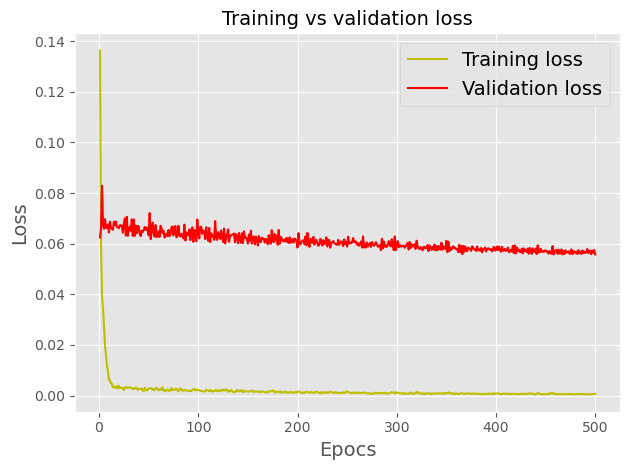

In [265]:
from matplotlib import pyplot as plt
loss = history.history['loss']
val_loss =history.history['val_loss']
epocs = range(1, len(loss) + 1)
plt.plot(epocs,loss, 'y', label = 'Training loss')
plt.plot(epocs, val_loss, 'r', label = 'Validation loss')
plt.title('Training vs validation loss')
plt.xlabel('Epocs')
plt.ylabel('Loss')
plt.style.use('ggplot')
plt.legend()
save_fig ("Training vs validation loss for dese layer")
plt.show()


<function matplotlib.pyplot.show(close=None, block=None)>

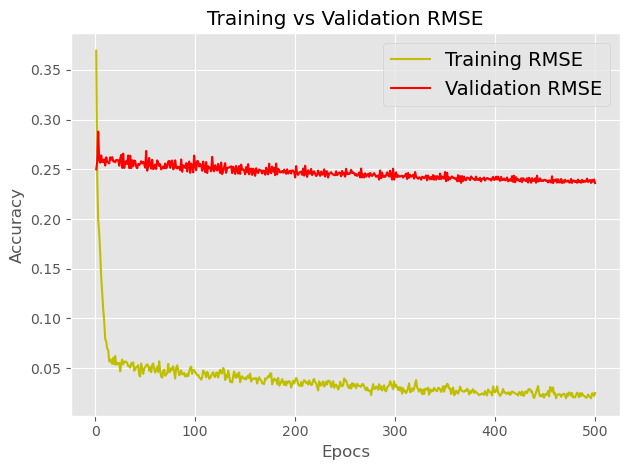

In [266]:
from matplotlib import pyplot as plt2
acc = history.history['root_mean_squared_error']
val_acc = history.history['val_root_mean_squared_error']
plt2.plot(epocs,acc, 'y', label = 'Training RMSE')
plt2.plot(epocs,val_acc, 'r', label = 'Validation RMSE')
plt2.title('Training vs Validation RMSE')
plt2.xlabel('Epocs')
plt2.ylabel('Accuracy')
plt2.style.use('ggplot')
plt2.legend()
save_fig ("Training vs Validation RMSE for dese layer")
plt2.show


### Prediction on test data

In [267]:
predictions = dmodel.predict(X_test[:15])
print("Predicted values are:", predictions)
print("Real values are: ", y_test[:15])

1/1 [==============================] - 0s 53ms/step
Predicted values are: [[0.5535381 ]
 [0.6197943 ]
 [0.5818565 ]
 [0.5856541 ]
 [0.53170085]
 [0.5518392 ]
 [0.57477754]
 [0.5688723 ]
 [0.53864896]
 [0.5636721 ]
 [0.5503957 ]
 [0.6034088 ]
 [0.55270565]
 [0.5210842 ]
 [0.5225597 ]]
Real values are:  17     0.000007
183    0.990870
126    0.499026
8      0.998055
4      0.992778
108    0.499238
75     0.501441
122    0.992774
24     0.499020
41     0.499538
12     0.994893
43     0.498653
148    0.499026
180    0.994888
86     0.501440
Name: Expectation Values, dtype: float64


# LSTM

### Ignore Warning

In [268]:
import warnings
warnings.filterwarnings('ignore')

### Import libaray

In [269]:
from tensorflow.keras.layers import LSTM

### Reshaping the data for model

In [270]:
X_train = np.expand_dims(X_train, -1)
X_test =  x_train = np.expand_dims(X_test, -1)

In [271]:
X_train.shape

(148, 186, 1)

### Model creation

In [272]:
model = Sequential()
model.add(LSTM(128,input_shape = (X_train.shape[1],X_train.shape[2]), activation = 'relu',return_sequences=True))
# model.add(Dropout(0.2))
model.add(LSTM(64, activation = 'relu', return_sequences=True))
# model.add(Dropout(0.2))
model.add(LSTM(64, activation = 'relu', return_sequences=True))
model.add(LSTM(64, activation = 'relu', return_sequences=True))
model.add(LSTM(32, activation = 'relu', return_sequences=False))
model.add(Dense(1))
model.compile(loss = 'mse', optimizer='adam' , metrics = [keras.metrics.RootMeanSquaredError()])
model.summary()

Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 186, 128)          66560     
                                                                 
 lstm_1 (LSTM)               (None, 186, 64)           49408     
                                                                 
 lstm_2 (LSTM)               (None, 186, 64)           33024     
                                                                 
 lstm_3 (LSTM)               (None, 186, 64)           33024     
                                                                 
 lstm_4 (LSTM)               (None, 32)                12416     
                                                                 
 dense_10 (Dense)            (None, 1)                 33        
                                                                 
Total params: 194,465
Trainable params: 194,465
Non-t

### Model evalution

In [273]:
history = model.fit(X_train,y_train, epochs=500, validation_data= (X_test,y_test))

Epoch 1/500
5/5 [==============================] - 12s 1s/step - loss: 0.2819 - root_mean_squared_error: 0.5310 - val_loss: 0.3317 - val_root_mean_squared_error: 0.5759
Epoch 2/500
5/5 [==============================] - 5s 1s/step - loss: 0.2036 - root_mean_squared_error: 0.4512 - val_loss: 0.1748 - val_root_mean_squared_error: 0.4181
Epoch 3/500
5/5 [==============================] - 6s 1s/step - loss: 0.0817 - root_mean_squared_error: 0.2859 - val_loss: 0.0518 - val_root_mean_squared_error: 0.2277
Epoch 4/500
5/5 [==============================] - 5s 1s/step - loss: 0.0478 - root_mean_squared_error: 0.2187 - val_loss: 0.0797 - val_root_mean_squared_error: 0.2823
Epoch 5/500
5/5 [==============================] - 6s 1s/step - loss: 0.0538 - root_mean_squared_error: 0.2319 - val_loss: 0.0722 - val_root_mean_squared_error: 0.2688
Epoch 6/500
5/5 [==============================] - 5s 1s/step - loss: 0.0490 - root_mean_squared_error: 0.2213 - val_loss: 0.0536 - val_root_mean_squared_error

### Plotting the result

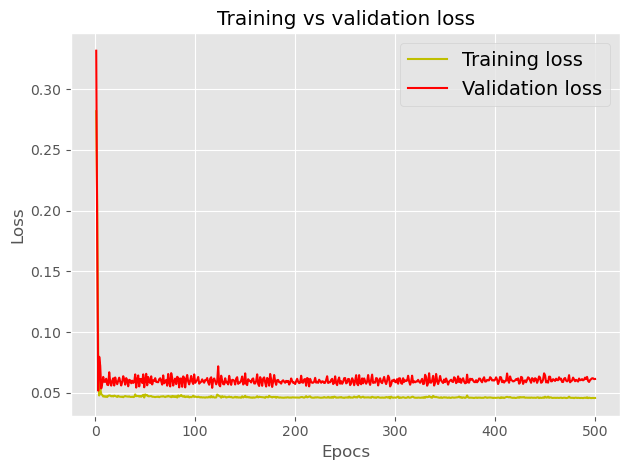

In [274]:
from matplotlib import pyplot as plt3
loss = history.history['loss']
val_loss =history.history['val_loss']
epocs = range(1, len(loss) + 1)
plt3.plot(epocs,loss, 'y', label = 'Training loss')
plt3.plot(epocs, val_loss, 'r', label = 'Validation loss')
plt3.title('Training vs validation loss')
plt3.xlabel('Epocs')
plt3.ylabel('Loss')
plt3.style.use('ggplot')
plt3.legend()
save_fig ("Training vs validation loss for LSTM")
plt3.show()

<function matplotlib.pyplot.show(close=None, block=None)>

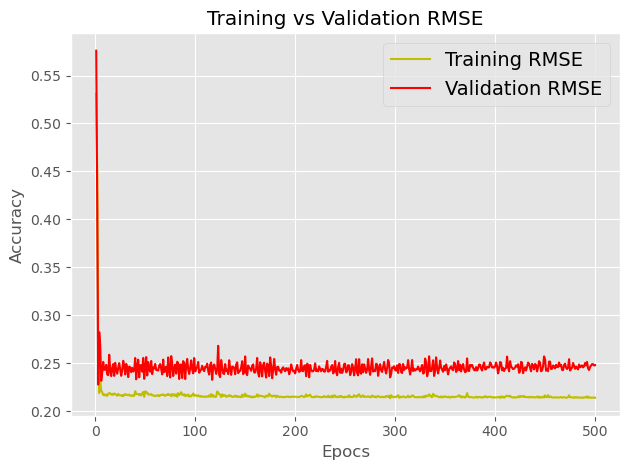

In [275]:
from matplotlib import pyplot as plt4
acc = history.history['root_mean_squared_error']
val_acc = history.history['val_root_mean_squared_error']
plt4.plot(epocs,acc, 'y', label = 'Training RMSE')
plt4.plot(epocs,val_acc, 'r', label = 'Validation RMSE')
plt4.title('Training vs Validation RMSE')
plt4.xlabel('Epocs')
plt4.ylabel('Accuracy')
plt4.style.use('ggplot')
plt4.legend()
save_fig ("Training vs Validation RMSE for LSTM")
plt4.show

### Prediction on test data

In [276]:
predictions = model.predict(X_test[:15])
print("Predicted values are:", predictions)
print("Real values are: ", y_test[:15])

1/1 [==============================] - 1s 1s/step
Predicted values are: [[0.492437  ]
 [0.5243907 ]
 [0.49242696]
 [0.49225345]
 [0.49234357]
 [0.4929837 ]
 [0.4924144 ]
 [0.49243873]
 [0.49241912]
 [0.49241576]
 [0.49234357]
 [0.4924115 ]
 [0.4924195 ]
 [0.49243897]
 [0.7000144 ]]
Real values are:  17     0.000007
183    0.990870
126    0.499026
8      0.998055
4      0.992778
108    0.499238
75     0.501441
122    0.992774
24     0.499020
41     0.499538
12     0.994893
43     0.498653
148    0.499026
180    0.994888
86     0.501440
Name: Expectation Values, dtype: float64


# Bi -LSTM

### Ignore Warning

In [277]:
import warnings
warnings.filterwarnings('ignore')

### Import libaray

In [278]:
import keras
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, Dense

### Reshaping data for model

In [279]:
X_train = np.expand_dims(X_train, -1)
X_test =  x_train = np.expand_dims(X_test, -1)

### Model creation

In [280]:
bmodel = Sequential()
bmodel.add(LSTM(128,input_shape = (X_train.shape[1],X_train.shape[2]), activation = 'relu',return_sequences=True))
# model.add(Dropout(0.2))
bmodel.add(LSTM(64, activation = 'relu', return_sequences=True))
# model.add(Dropout(0.2))
bmodel.add(Bidirectional(LSTM(64, activation = 'relu', return_sequences=True)))
bmodel.add(Bidirectional(LSTM(64, activation = 'relu', return_sequences=True)))
bmodel.add(LSTM(32, activation = 'relu', return_sequences=False))
bmodel.add(Dense(1))
bmodel.compile(loss = 'mse', optimizer='adam' , metrics = [keras.metrics.RootMeanSquaredError()])
bmodel.summary()

Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 186, 128)          66560     
                                                                 
 lstm_6 (LSTM)               (None, 186, 64)           49408     
                                                                 
 bidirectional (Bidirectiona  (None, 186, 128)         66048     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 186, 128)         98816     
 nal)                                                            
                                                                 
 lstm_9 (LSTM)               (None, 32)                20608     
                                                                 
 dense_11 (Dense)            (None, 1)               

### Model evalution

In [281]:
history = bmodel.fit(X_train,y_train, epochs=100, batch_size = 15,validation_data= (X_test,y_test))

Epoch 1/100
10/10 [==============================] - 24s 2s/step - loss: 0.2438 - root_mean_squared_error: 0.4938 - val_loss: 0.1796 - val_root_mean_squared_error: 0.4238
Epoch 2/100
10/10 [==============================] - 12s 1s/step - loss: 0.0704 - root_mean_squared_error: 0.2654 - val_loss: 0.0932 - val_root_mean_squared_error: 0.3053
Epoch 3/100
10/10 [==============================] - 12s 1s/step - loss: 0.0553 - root_mean_squared_error: 0.2352 - val_loss: 0.0543 - val_root_mean_squared_error: 0.2331
Epoch 4/100
10/10 [==============================] - 14s 1s/step - loss: 0.0482 - root_mean_squared_error: 0.2195 - val_loss: 0.0649 - val_root_mean_squared_error: 0.2548
Epoch 5/100
10/10 [==============================] - 14s 1s/step - loss: 0.0489 - root_mean_squared_error: 0.2212 - val_loss: 0.0599 - val_root_mean_squared_error: 0.2447
Epoch 6/100
10/10 [==============================] - 12s 1s/step - loss: 0.0471 - root_mean_squared_error: 0.2171 - val_loss: 0.0582 - val_root_m

### Plotting the result

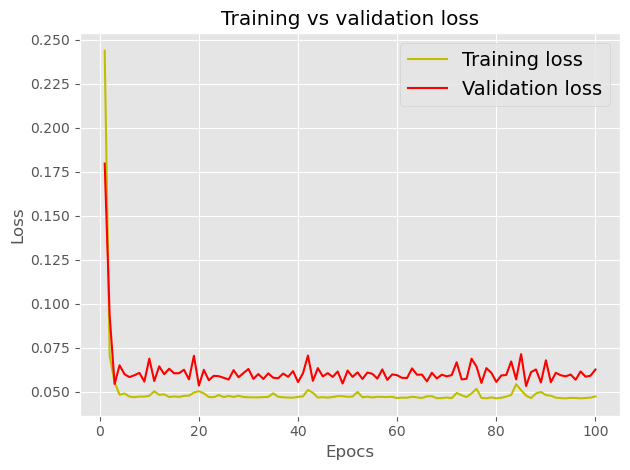

In [282]:
from matplotlib import pyplot as plt5
loss = history.history['loss']
val_loss =history.history['val_loss']
epocs = range(1, len(loss) + 1)
plt5.plot(epocs,loss, 'y', label = 'Training loss')
plt5.plot(epocs, val_loss, 'r', label = 'Validation loss')
plt5.title('Training vs validation loss')
plt5.xlabel('Epocs')
plt5.ylabel('Loss')
plt5.style.use('ggplot')
plt5.legend()
save_fig ("Training vs validation loss for BI-LSTM")
plt5.show()

<function matplotlib.pyplot.show(close=None, block=None)>

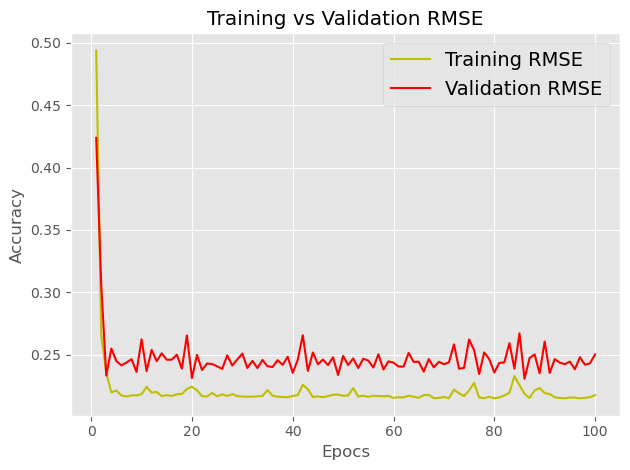

In [283]:
from matplotlib import pyplot as plt6
acc = history.history['root_mean_squared_error']
val_acc = history.history['val_root_mean_squared_error']
plt6.plot(epocs,acc, 'y', label = 'Training RMSE')
plt6.plot(epocs,val_acc, 'r', label = 'Validation RMSE')
plt6.title('Training vs Validation RMSE')
plt6.xlabel('Epocs')
plt6.ylabel('Accuracy')
plt6.style.use('ggplot')
plt6.legend()
save_fig ("Training vs Validation RMSE for for BI-LSTM")
plt6.show

### Prediction on test data

In [284]:
predictions = bmodel.predict(X_test[:15])
print("Predicted values are:", predictions)
print("Real values are: ", y_test[:15])

1/1 [==============================] - 1s 1s/step
Predicted values are: [[0.47869328]
 [0.5507385 ]
 [0.47833714]
 [0.47581246]
 [0.4770347 ]
 [0.4781024 ]
 [0.47822592]
 [0.47871998]
 [0.47833377]
 [0.47826567]
 [0.47703466]
 [0.47817954]
 [0.47834092]
 [0.4786829 ]
 [0.57410294]]
Real values are:  17     0.000007
183    0.990870
126    0.499026
8      0.998055
4      0.992778
108    0.499238
75     0.501441
122    0.992774
24     0.499020
41     0.499538
12     0.994893
43     0.498653
148    0.499026
180    0.994888
86     0.501440
Name: Expectation Values, dtype: float64


# Feature Importance

In [285]:
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestRegressor
iris = load_iris(as_frame=True)
rf = RandomForestRegressor(n_estimators= 200, max_depth=500, random_state=0)

rf.fit(iris.data, iris.target)
for score, name in zip(rf.feature_importances_, iris.data.columns):
    print(round(score, 2), name)

0.01 sepal length (cm)
0.01 sepal width (cm)
0.48 petal length (cm)
0.51 petal width (cm)


In [286]:
rf.feature_importances_

array([0.00564135, 0.00721837, 0.48025529, 0.50688498])

# Save fig function

In [287]:
# Save figure function
import os
from pathlib import Path
from matplotlib import pyplot as plt
IMAGES_PATH = Path() / "IMAGES" 
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Explanation of the prediction using XAI 

### LIME

### Import libaray

In [288]:
import lime
import lime.lime_tabular
import numpy as np
import IPython
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

### Explainer

In [289]:

rf = RandomForestRegressor()
rf.fit(exp_X_train, exp_y_train)

RandomForestRegressor()

In [290]:
explainer = lime.lime_tabular.LimeTabularExplainer(training_data = exp_X_train.values,
    mode="regression",
    feature_names=exp_X_train.columns)

In [291]:
exp_X_test = np.array(exp_X_test)

In [292]:
restore = exp_X_test[0]

In [293]:
print(restore)

[0.         0.         0.         1.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         

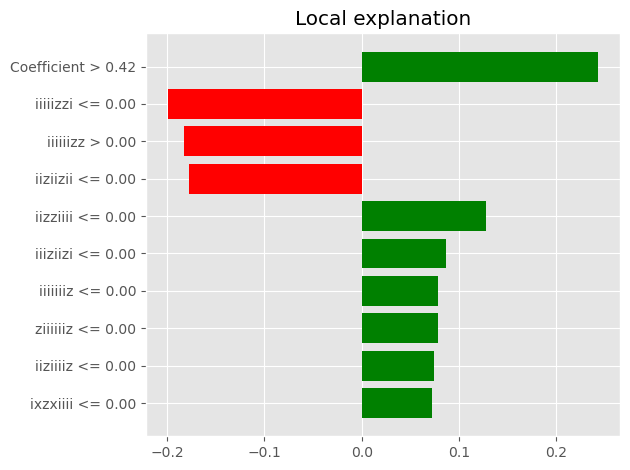

In [294]:
explanation = explainer.explain_instance(exp_X_test[0], rf.predict )
explanation
explanation.as_map()
explanation.as_pyplot_figure()
save_fig ("XAI explanation of model prediction")

In [295]:
explanation.show_in_notebook(show_all=False)

In [296]:
pd.DataFrame(explanation.as_list(),columns=['Feature','Contribution'])

Feature  Contribution
0  Coefficient > 0.42      0.243273
1    iiiiizzi <= 0.00     -0.199655
2     iiiiiizz > 0.00     -0.182558
3    iiziizii <= 0.00     -0.177544
4    iizziiii <= 0.00      0.127891
5    iiiziizi <= 0.00      0.086544
6    iiiiiiiz <= 0.00      0.078512
7    ziiiiiiz <= 0.00      0.078032
8    iiziiiiz <= 0.00      0.074650
9    ixzxiiii <= 0.00      0.071965

# SHARP

### Import libaray

In [297]:
import shap
import matplotlib.pyplot as plt7

### Explainer

In [298]:


# load JS visualization code to notebook
shap.initjs()

# Create the explainer
explainer = shap.TreeExplainer(rf)

shap_values = explainer.shap_values(exp_X_test, check_additivity=False)

XAI explanation of model prediction using sharp


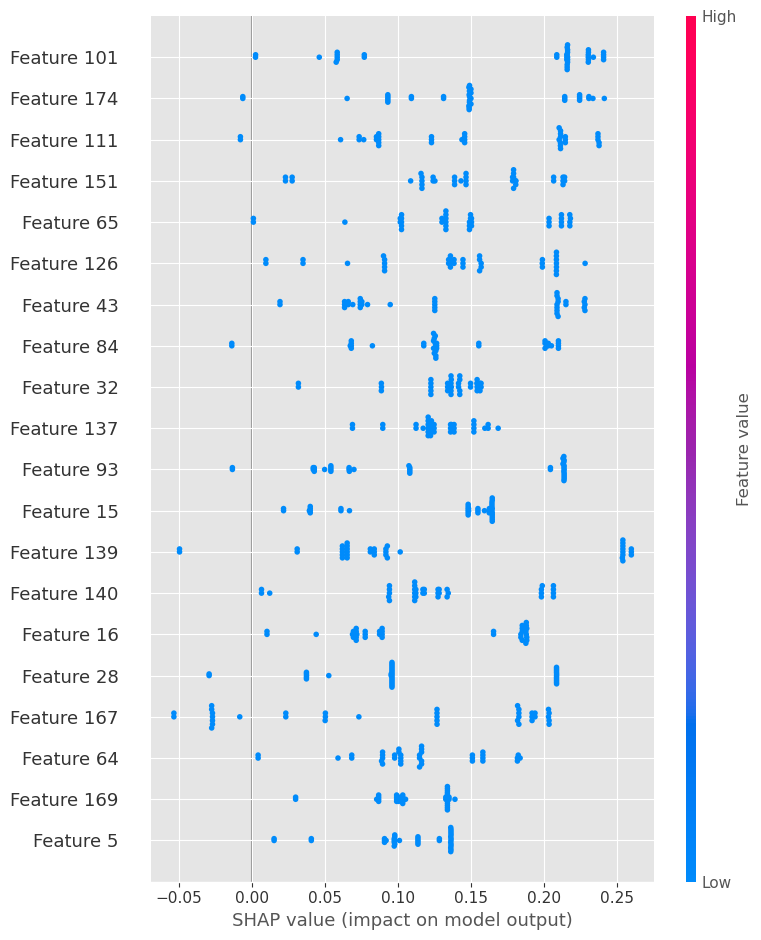

<Figure size 640x480 with 0 Axes>

In [299]:
print("XAI explanation of model prediction using sharp")
# figure = plt7.figure()
shap.summary_plot(shap_values, exp_X_test)
plt7.show()
save_fig ("SHARP XAI explanation of medel prediction")

# Decesion Tree

### Import libaray

In [300]:
from sklearn import tree

### Explainer

In [301]:
# Get the class names
class_names = exp_y_train

# Get the feature names
feature_names = list(exp_X_train.columns)

In [302]:
dtr = tree.DecisionTreeRegressor()

In [303]:
dtr.fit(exp_X_train, exp_y_train)

DecisionTreeRegressor()

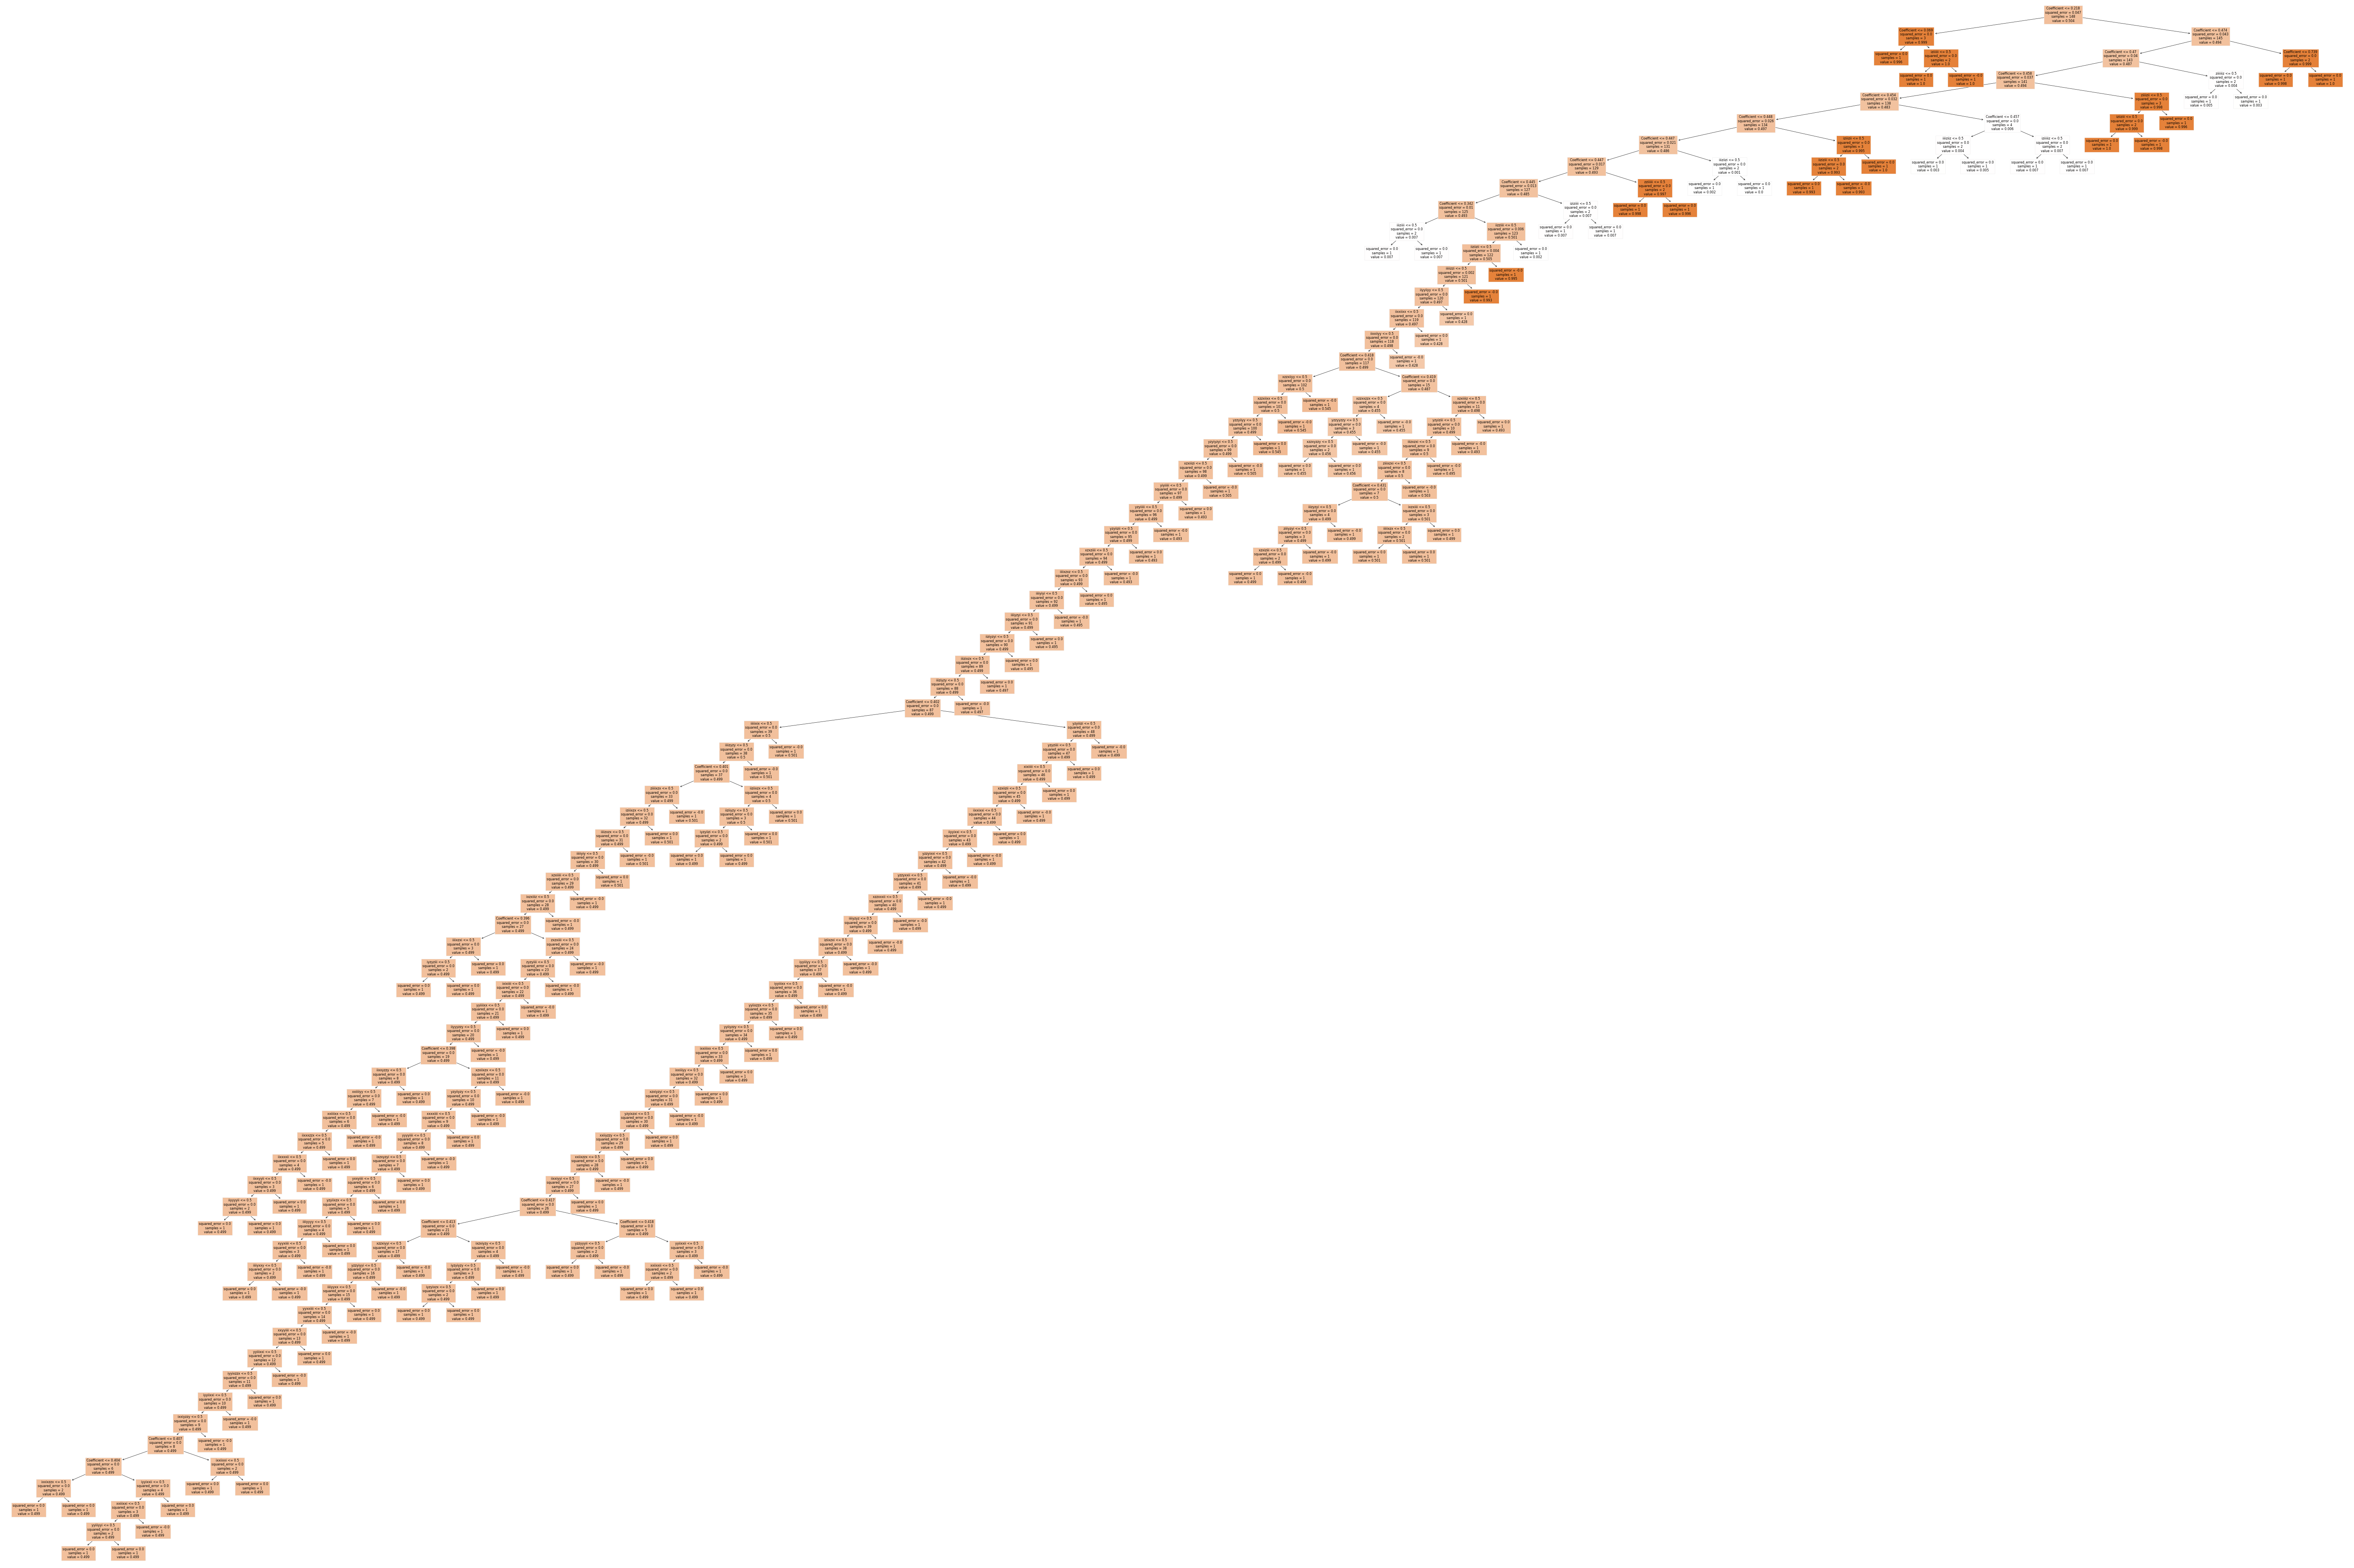

In [304]:
from sklearn.tree import plot_tree
fig = plt.figure(figsize=(60,40))
_ = plot_tree(dtr,
               	feature_names = feature_names,
               	class_names = class_names,
               	filled=True)
save_fig ("Decesion tree explanation of model")